<a href="https://colab.research.google.com/github/shenghaoc/ee5907-ca2/blob/main/lda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from PIL import Image
from pathlib import Path


In [2]:
# CONSTANTS
NUM_SUBJECTS = 68
NUM_CHOSEN = 25
NUM_IMAGES_PER_SUBJECT = 170

TRAIN_RATIO = 0.7
NUM_IMAGES = NUM_CHOSEN * NUM_IMAGES_PER_SUBJECT
NUM_TRAIN_IMAGES_PER_SUBJECT = np.int_(np.around(TRAIN_RATIO * NUM_IMAGES_PER_SUBJECT))
NUM_TRAIN_IMAGES = NUM_CHOSEN * NUM_TRAIN_IMAGES_PER_SUBJECT
NUM_TEST_IMAGES = NUM_IMAGES - NUM_TRAIN_IMAGES

NUM_SELFIES = 10
NUM_TRAIN_SELFIES = np.int_(np.around(TRAIN_RATIO * NUM_SELFIES))
NUM_TEST_SELFIES = NUM_SELFIES - NUM_TRAIN_SELFIES
SELFIE_LABEL = NUM_SUBJECTS + 1

NUM_TOTAL_TRAIN_IMAGES = NUM_TRAIN_IMAGES + NUM_TRAIN_SELFIES
NUM_TOTAL_TEST_IMAGES = NUM_TEST_IMAGES + NUM_TEST_SELFIES

SEED1 = 2021
SEED2 = 2022

WIDTH = 32
HEIGHT = 32
NUM_PIXELS = WIDTH * HEIGHT


In [3]:
# Ensure that the directory to store figures is created
figures_directory = Path("report") / "figures"
figures_directory.mkdir(exist_ok=True)


In [4]:
# Must start from 1 to accommodate folder naming scheme
# Choose NUM_CHOSEN elements from NUM_SUBJECTS integers without replacement
chosen = np.random.default_rng(SEED1).choice(
    np.arange(1, NUM_SUBJECTS + 1), NUM_CHOSEN, replace=False
)


In [5]:
# Load images from disk
# Use lists for manual looping without use of numpy functions
images = []
labels = []

# Assume PIE is in pwd
directory = Path("PIE")
for i in chosen:
    # Do not flatten yet, need to split train and test for each subject
    subject_images = []
    subject_labels = []
    subdirectory = directory / str(i)
    # Order is arbitrary for glob, but better to shuffle anyway
    files = list(subdirectory.glob("*.jpg"))
    np.random.default_rng(SEED2).shuffle(files)
    for filename in files:
        # PIL is slower but OpenCV is unnecessary
        im = Image.open(filename)
        subject_images.append(np.array(im))
        subject_labels.append(i)  # Use number in PIE for label
    images.append(subject_images)
    labels.append(subject_labels)


In [6]:
# Slightly altered code for selfies
selfie_images = []
selfie_labels = []

directory = Path("resized")
# Assume selfies have been resized and folder is in pwd
for filename in directory.glob("*.jpg"):
    im = Image.open(filename)
    selfie_images.append(np.array(im))
    selfie_labels.append(SELFIE_LABEL)  # add 1 to max PIE number to avoid clashes


In [7]:
# Further processing without disk access
# Train-test split
images_train, images_test = np.split(
    np.array(images), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1
)
labels_train, labels_test = np.split(
    np.array(labels), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1
)

selfie_images_train, selfie_images_test = np.split(
    np.array(selfie_images), [NUM_TRAIN_SELFIES]
)
selfie_labels_train, selfie_labels_test = np.split(
    np.array(selfie_labels), [NUM_TRAIN_SELFIES]
)


In [8]:
# Flatterning
images_train = images_train.reshape(NUM_TRAIN_IMAGES, NUM_PIXELS)
selfie_images_train = selfie_images_train.reshape(NUM_TRAIN_SELFIES, NUM_PIXELS)
images_test = images_test.reshape(NUM_TEST_IMAGES, NUM_PIXELS)
selfie_images_test = selfie_images_test.reshape(NUM_TEST_SELFIES, NUM_PIXELS)

labels_train = labels_train.reshape(NUM_TRAIN_IMAGES)
labels_test = labels_test.reshape(NUM_TEST_IMAGES)

# Combine PIE images and selfies
total_images_train = np.append(
    images_train,
    selfie_images_train,
    axis=0,
)
total_labels_train = np.append(labels_train, selfie_labels_train)

total_images_test = np.append(
    images_test,
    selfie_images_test,
    axis=0,
)
total_labels_test = np.append(labels_test, selfie_labels_test)


In [9]:
# Start of LDA code
import matplotlib.pyplot as plt
from numpy import linalg as LA
from numpy.linalg import inv


In [10]:
# CONSTANTS
LDA_SAMPLE_SIZE = 500
# Need to manually adjust this so that at least one selfie is included in the sample
SEED3 = 2020
MAX_LDA_DIM = 9


In [11]:
chosen = np.random.default_rng(SEED3).choice(
    np.arange(NUM_TOTAL_TRAIN_IMAGES), LDA_SAMPLE_SIZE, replace=False
)


In [12]:
# According to most sources
# rows: n data points (500)
# columns: p features (1024)
X_train = total_images_train
y_train = total_labels_train


In [13]:
# LDA
# This is the same random sampled data from PCA, hence labels are repeated and
# not in order

# Each label also has different number of samples, hindering vectorization due
# to numpy's limitation

# I use the name labels instead of classes because class cannot be a variable name in
# Python

# First, get sorted, unique labels
unique_labels = np.unique(y_train)
label_feature_means = np.zeros((len(unique_labels), NUM_PIXELS))

within_label_scatter_matrix = np.zeros((NUM_PIXELS, NUM_PIXELS))

for i in range(len(unique_labels)):
    label = unique_labels[i]
    label_samples = X_train[y_train == label]  # get sample with current label
    label_feature_means[i] = np.mean(
        label_samples, axis=0
    )  # mean of features for current label

    s = np.zeros_like(within_label_scatter_matrix)
    for label_sample in label_samples:
        s += np.outer(
            (label_sample - label_feature_means[i]),
            (label_sample - label_feature_means[i]),
        )

    within_label_scatter_matrix += s


In [14]:
feature_means = np.mean(X_train, axis=0)

between_label_scatter_matrix = np.zeros_like(within_label_scatter_matrix)

for i in range(len(unique_labels)):
    label = unique_labels[i]
    n = np.count_nonzero(y_train == label)  # number of samples with current label
    between_label_scatter_matrix += n * np.outer(
        (label_feature_means[i] - feature_means),
        (label_feature_means[i] - feature_means),
    )


In [15]:
eigvals, eigvecs = LA.eig(
    inv(within_label_scatter_matrix) @ between_label_scatter_matrix
)


In [16]:
order = np.argsort(-eigvals)  # -ve for DESC order
eigvals = eigvals[order]
eigvecs = eigvecs[:, order].real  # eig returns complex type by default


In [17]:
# Projection on to highest dimension
#
X_lda = X_train @ eigvecs[:, :MAX_LDA_DIM]
selfie_X_lda = X_lda[y_train == SELFIE_LABEL]
pie_X_lda = X_lda[y_train != SELFIE_LABEL]


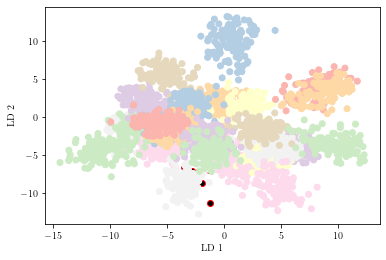

In [18]:
# LDA 2D
fig = plt.figure()
ax = fig.add_subplot()

# First, check for selfie and draw red edge
ax.scatter(
    selfie_X_lda[:, 0],
    selfie_X_lda[:, 1],
    c="k",
    edgecolors="r",
)
# Next, check not selfie and draw normally
# Also use a distinct color map for clarity
ax.scatter(
    pie_X_lda[:, 0],
    pie_X_lda[:, 1],
    c=y_train[y_train != SELFIE_LABEL],
    cmap="Pastel1",
)

ax.set_xlabel("LD 1")
ax.set_ylabel("LD 2")

plt.savefig(figures_directory / "lda_2d.pdf")


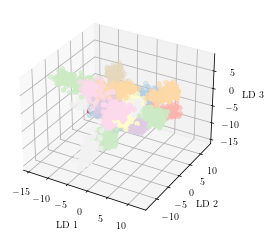

In [19]:
# LDA 3D
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.scatter(
    selfie_X_lda[:, 0],
    selfie_X_lda[:, 1],
    selfie_X_lda[:, 2],
    c="k",
    edgecolors="r",
)
ax.scatter(
    pie_X_lda[:, 0],
    pie_X_lda[:, 1],
    pie_X_lda[:, 2],
    c=y_train[y_train != SELFIE_LABEL],
    cmap="Pastel1",
)

ax.set_xlabel("LD 1")
ax.set_ylabel("LD 2")
ax.set_zlabel("LD 3")

plt.savefig(figures_directory / "lda_3d.pdf")


In [20]:
X_lda_test = images_test @ eigvecs[:, :MAX_LDA_DIM]
selfie_X_lda_test = selfie_images_test @ eigvecs[:, :MAX_LDA_DIM]


In [21]:
def calc_acc_with_dimension(dim, c, y):
    dist_arr_test = LA.norm(c[:, :dim][:, np.newaxis] - X_lda[:, :dim], axis=2)
    dist_arr_test = np.argsort(dist_arr_test)  # get the indices (cols) in sorted order

    k = 1  # Unique person
    # Get knn indices then use them to access label
    knn_indices = dist_arr_test[:, :k]
    knn_labels = y_train[knn_indices]

    # Original rows (X values we want to check) are preserved, so we apply
    # KNN formula to each row, but ignore k since its constant here
    result = knn_labels[:, 0]
    acc = np.sum(result == y) / y.size

    return acc


def calc_acc(c, y):
    for i in [2, 3, 9]:
        print(
            "Accuracy with dim",
            i,
            "=",
            calc_acc_with_dimension(i, c, y),
        )


print("For PIE:")
calc_acc(X_lda_test, labels_test)
print("For selfies:")
calc_acc(selfie_X_lda_test, selfie_labels_test)


For PIE:
Accuracy with dim 2 = 0.4768627450980392
Accuracy with dim 3 = 0.6815686274509803
Accuracy with dim 9 = 0.9419607843137255
For selfies:
Accuracy with dim 2 = 0.0
Accuracy with dim 3 = 0.0
Accuracy with dim 9 = 0.3333333333333333
